<div align="center">

### **Exploratory Data Analysis on NASDAQ and NYSE Indexes**

</div>

The **NASDAQ** and **NYSE** are two important stock market indexes. They help us understand the health of the stock market and the economy. In this master's thesis, I use `yfinance` to get the data about these indexes. <br><br>

<div align="justify">

First, I will look at the data using charts and graphs to see the main trends and any unusual points. I will also study the data to see if past values can help predict future ones, a concept known as autoregression. To make the analysis richer, I will add more data points called exogenous variables and also use some common tools from finance, called technical indicators. <br><br>

But the world of finance is big and everything is connected. So, I will also look at stock markets from other big countries, and the prices of things like gold, silver, gas, oil, and even digital currencies like Bitcoin. By comparing all these data points, I want to see how they move in relation to the NASDAQ and NYSE. Do they move together? Or do they move in opposite directions? These are some of the questions this thesis aims to answer.

</div>

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
import time

from sklearn import preprocessing as pre
from sklearn import metrics as met

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import yfinance as yf

In [2]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="5y")
df_NASDAQ.tail()

Open     High      Low    Close      Volume  \
Date                                                                        
2023-08-15 00:00:00-04:00 13760.48 13774.98 13611.94 13631.05  4473320000   
2023-08-16 00:00:00-04:00 13593.17 13644.32 13473.03 13474.63  6243760000   
2023-08-17 00:00:00-04:00 13527.30 13535.09 13303.45 13316.93  5280180000   
2023-08-18 00:00:00-04:00 13190.02 13335.87 13161.76 13290.78  4801910000   
2023-08-21 00:00:00-04:00 13347.30 13461.31 13325.59 13454.95  2414582000   

                           Dividends  Stock Splits  
Date                                                
2023-08-15 00:00:00-04:00       0.00          0.00  
2023-08-16 00:00:00-04:00       0.00          0.00  
2023-08-17 00:00:00-04:00       0.00          0.00  
2023-08-18 00:00:00-04:00       0.00          0.00  
2023-08-21 00:00:00-04:00       0.00          0.00

In [3]:
df_NASDAQ = df_NASDAQ[["Open","High","Low","Close","Volume"]]
df_NASDAQ.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [4]:
df_NASDAQ.describe(include="all")

Open     High      Low    Close         Volume
count  1258.00  1258.00  1258.00  1258.00        1258.00
mean  11077.02 11162.34 10983.33 11078.16  4065204031.80
std    2630.91  2644.92  2610.78  2628.83  1486562598.21
min    6257.86  6355.18  6190.17  6192.92   958950000.00
25%    8234.16  8272.45  8195.80  8243.38  2526830000.00
50%   11291.58 11415.50 11176.15 11322.79  4292705000.00
75%   13404.68 13562.73 13296.59 13425.48  4987852500.00
max   16120.92 16212.23 16017.23 16057.44 11621190000.00

In [5]:
df_NASDAQ.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Distribution of the Data

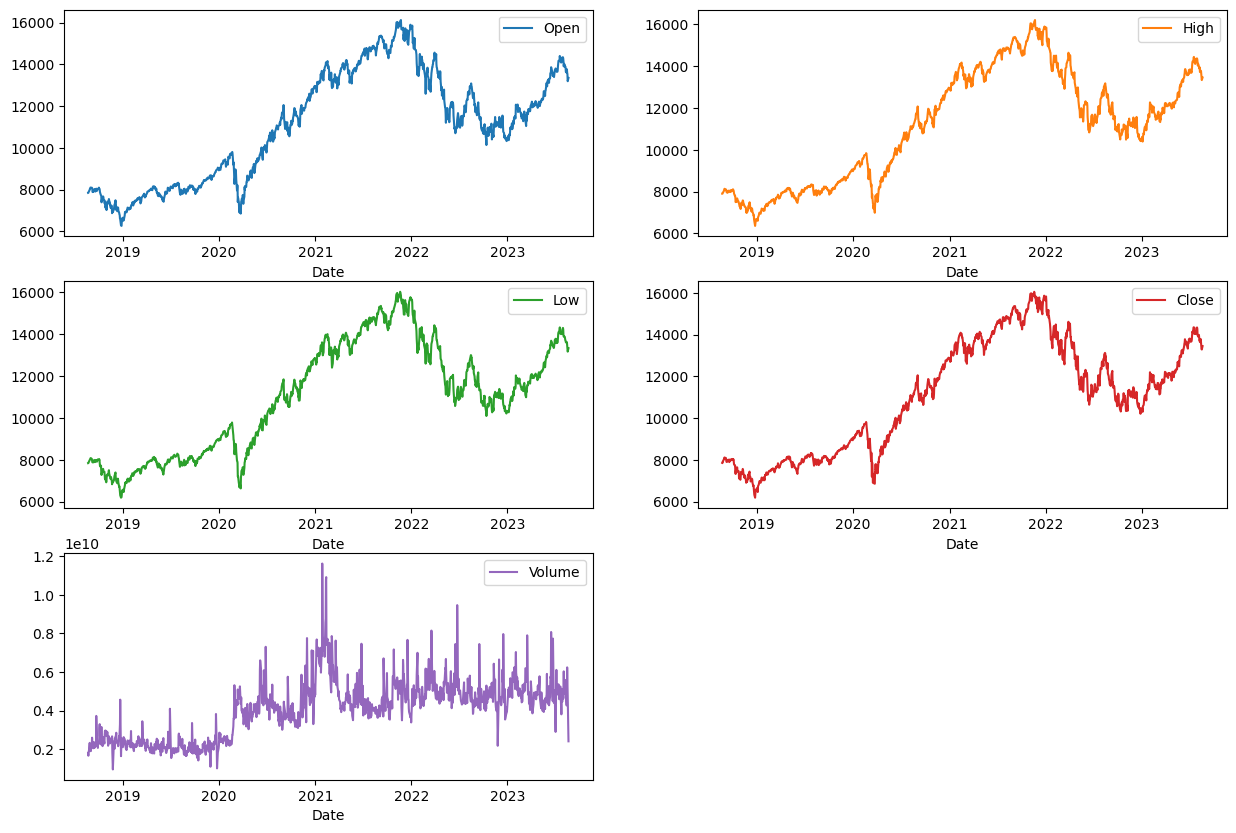

In [6]:
df_NASDAQ.plot(subplots = True,
               layout = (3, 2),
               figsize = (15, 10),
               sharex = False
              )
plt.show()

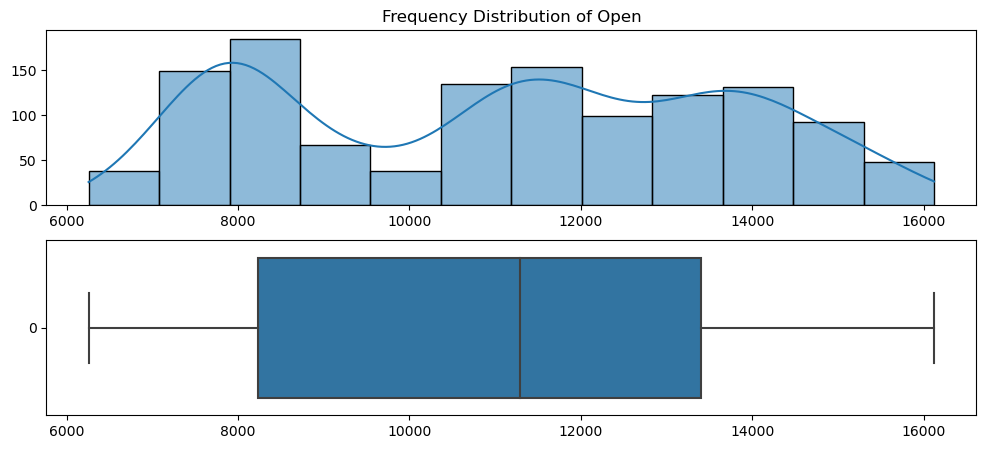

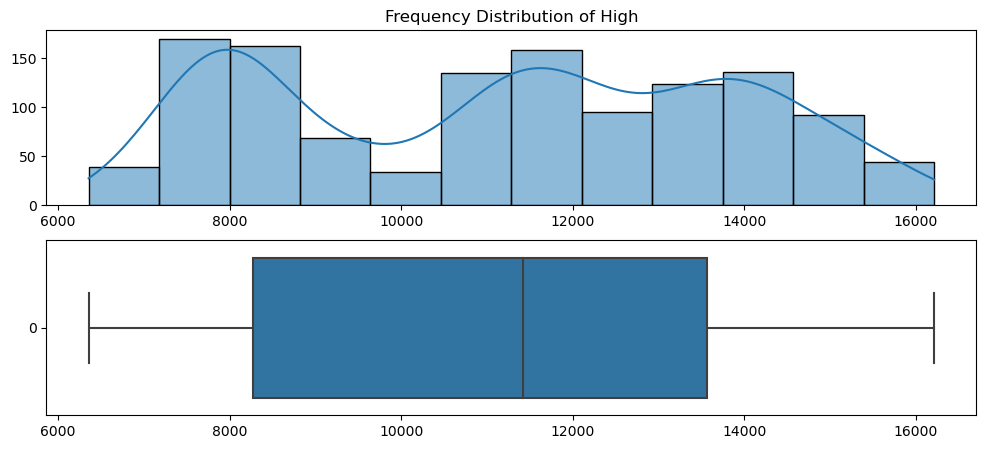

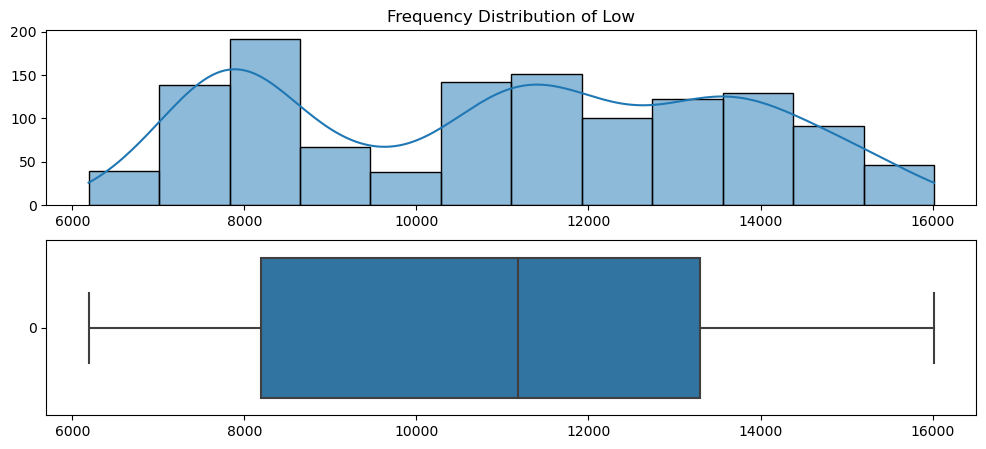

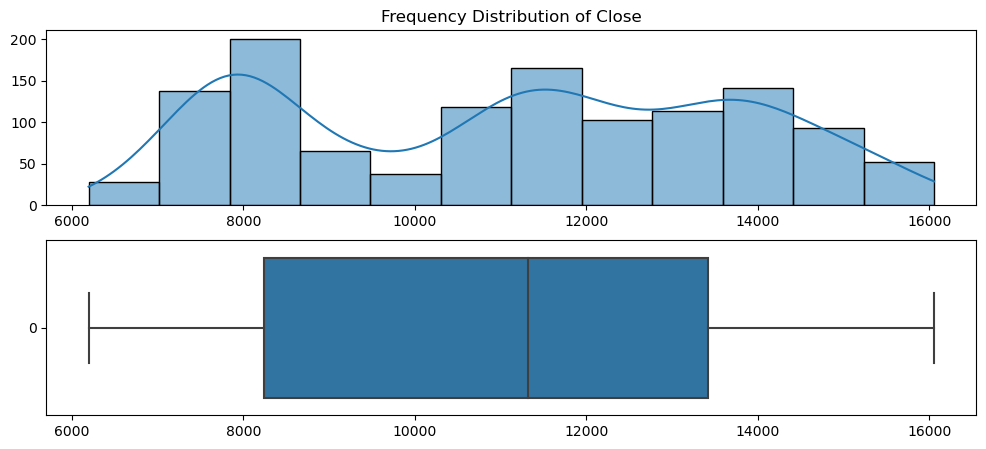

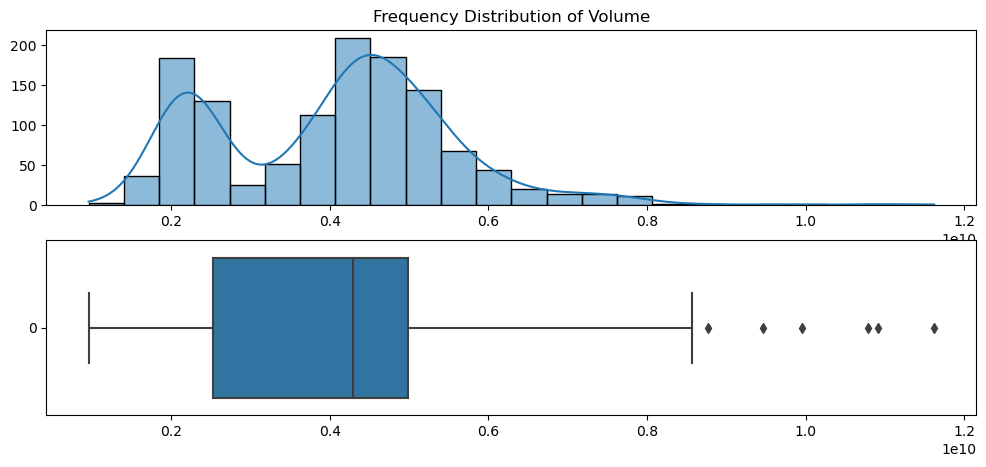

In [7]:
for col in df_NASDAQ.columns:
    fig, ax = plt.subplots(2,1, figsize = (12,5))
    sns.histplot(df_NASDAQ[col], kde = True, ax = ax[0])
    ax[0].set_title ("Frequency Distribution of" + " " + col, fontsize = 12)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    sns.boxplot(df_NASDAQ[col], orient = 'h', ax = ax[1])
    plt.show()

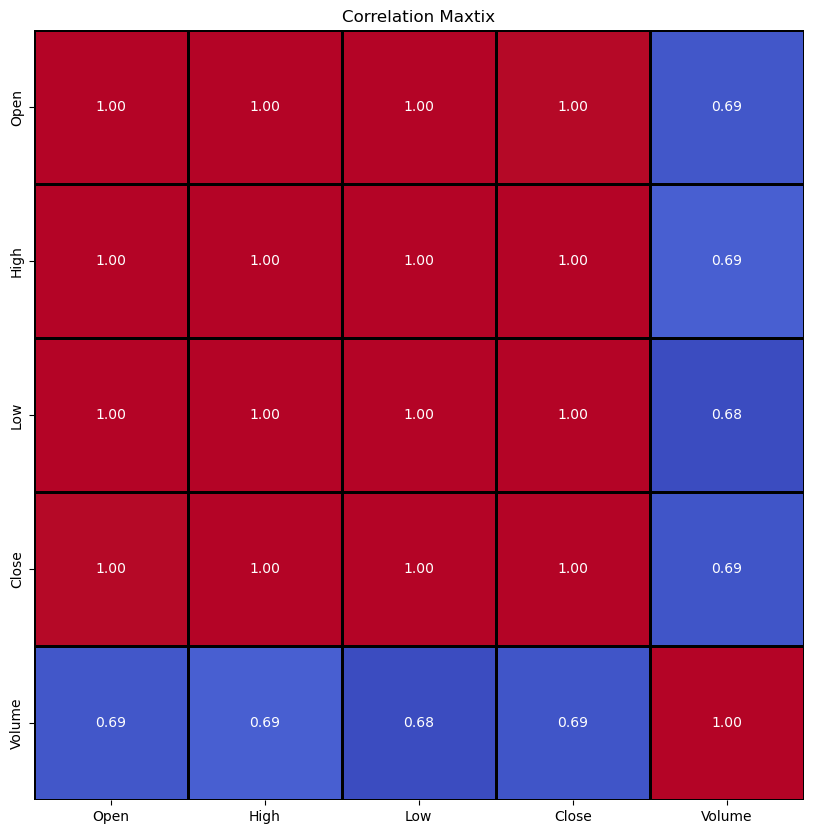

In [8]:
fig, ax = plt.subplots (figsize = (10, 10))
corr_matrix = df_NASDAQ.corr()

sns.heatmap(corr_matrix,
            cmap= "coolwarm",
            cbar= False,
            square=True,
            annot=True,
            linecolor="black",
            linewidths=1,
            fmt= ".2f",
            ax=ax
           )
ax.set_title("Correlation Maxtix", fontsize = 12)
plt.show()

## Autocorrelation

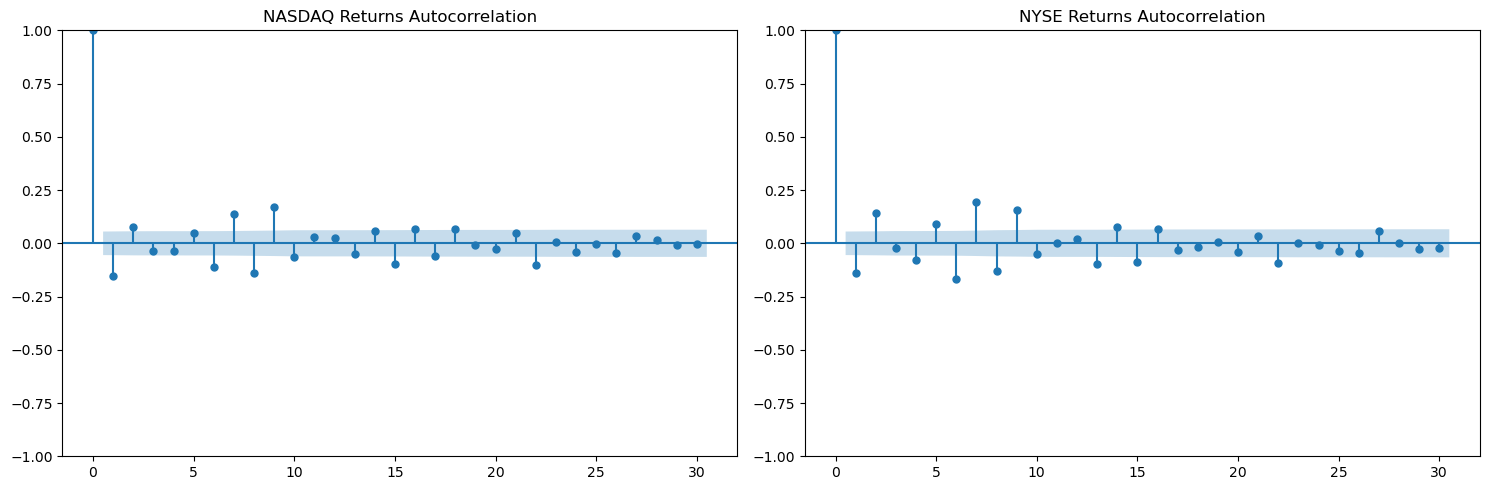

In [9]:
nasdaq = yf.Ticker("^IXIC")
nasdaq_returns = nasdaq.history(period="5y")
nasdaq_returns = nasdaq_returns['Close'].pct_change().dropna()*100

nyse = yf.Ticker('^NYA')
nyse_returns = nyse.history(period="5y")
nyse_returns = nyse_returns['Close'].pct_change().dropna()*100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(nasdaq_returns, lags=30, ax=ax[0], title="NASDAQ Returns Autocorrelation")
plot_acf(nyse_returns, lags=30, ax=ax[1], title="NYSE Returns Autocorrelation")

plt.tight_layout()
plt.show()

There seem to be some significant lags. I will take this into considiration while creating ARIMA models.

In [10]:
df_NASDAQ["dayofweek"]  = df_NASDAQ.index.dayofweek    
df_NASDAQ["weekofyear"] = df_NASDAQ.index.isocalendar().week.astype("int64") #change from Uint32 to int
df_NASDAQ["pct_close"]  = df_NASDAQ["Close"].pct_change().shift(1) * 100
df_NASDAQ["pct_close_abs"]  = np.abs(df_NASDAQ["pct_close"])
df_NASDAQ["win_close"]  = (df_NASDAQ["pct_close"] > 0).astype(int)
df_NASDAQ["pct_open"]   = pd.Series((df_NASDAQ['Open'] - df_NASDAQ['Close'].shift(1)) / df_NASDAQ['Close'].shift(1)).shift(1) * 100
df_NASDAQ["win_open"]   = (df_NASDAQ["pct_open"] > 0).astype(int)

df_NASDAQ["month"]      = df_NASDAQ.index.month
df_NASDAQ['dayofmonth'] = df_NASDAQ.index.day
df_NASDAQ.index = df_NASDAQ.index.date
df_NASDAQ.head()

Open    High     Low   Close      Volume  dayofweek  weekofyear  \
2018-08-21 7840.09 7897.68 7836.79 7859.17  1788860000          1          34   
2018-08-22 7844.04 7897.63 7840.84 7889.10  1669240000          2          34   
2018-08-23 7886.47 7926.32 7866.53 7878.46  1888600000          3          34   
2018-08-24 7907.81 7949.71 7907.10 7945.98  1892990000          4          34   
2018-08-27 7989.64 8024.94 7976.60 8017.90  2333790000          0          35   

            pct_close  win_close  pct_open  win_open  month  dayofmonth  
2018-08-21        NaN          0       NaN         0      8          21  
2018-08-22        NaN          0       NaN         0      8          22  
2018-08-23       0.38          1     -0.19         0      8          23  
2018-08-24      -0.13          0     -0.03         0      8          24  
2018-08-27       0.86          1      0.37         1      8          27

In [11]:
df_NASDAQ["pct_close"]

2018-08-21     NaN
2018-08-22     NaN
2018-08-23    0.38
2018-08-24   -0.13
2018-08-27    0.86
              ... 
2023-08-15    1.05
2023-08-16   -1.14
2023-08-17   -1.15
2023-08-18   -1.17
2023-08-21   -0.20
Name: pct_close, Length: 1258, dtype: float64

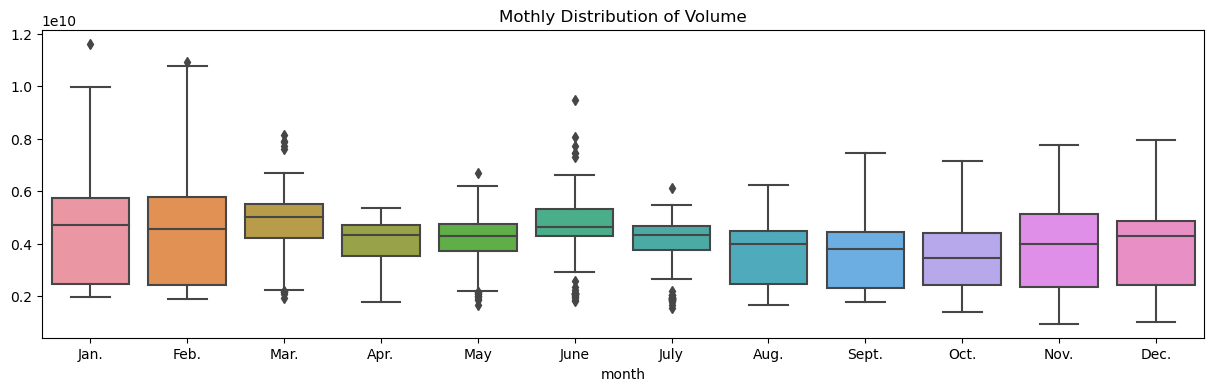

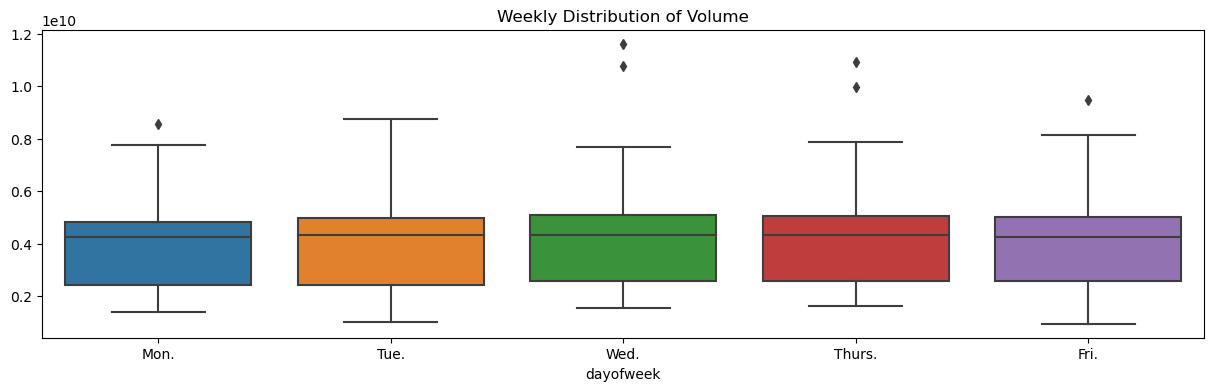

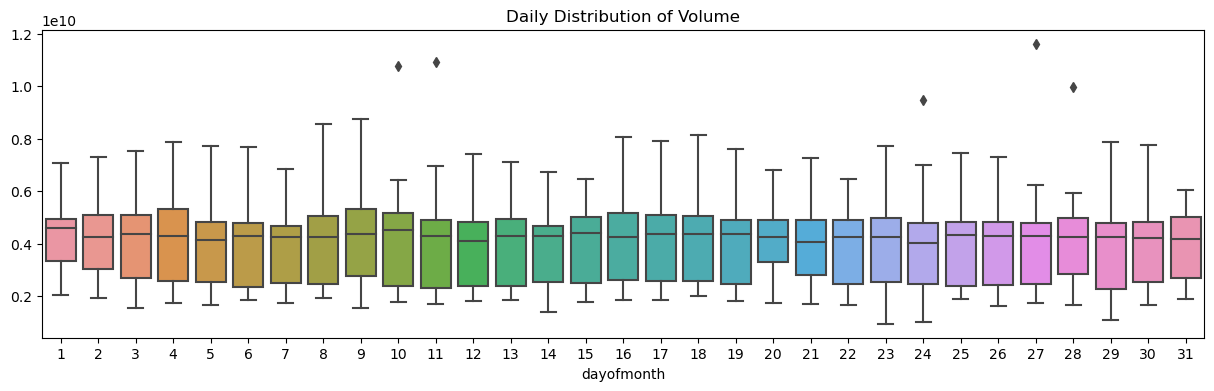

In [12]:
plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "month", y = 'Volume')
plt.ylabel("")
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11], labels = ["Jan.", "Feb.", "Mar.", "Apr.", "May", "June", "July", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."])
plt.title("Mothly Distribution of Volume")
plt.show()

plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "dayofweek", y = 'Volume')
plt.ylabel("")
plt.xticks(ticks = [0, 1,2,3,4], labels = ["Mon.", "Tue.", "Wed.", "Thurs.", "Fri."])
plt.title("Weekly Distribution of Volume")
plt.show()

plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "dayofmonth", y = 'Volume')
plt.ylabel("")
plt.title("Daily Distribution of Volume")
plt.show()

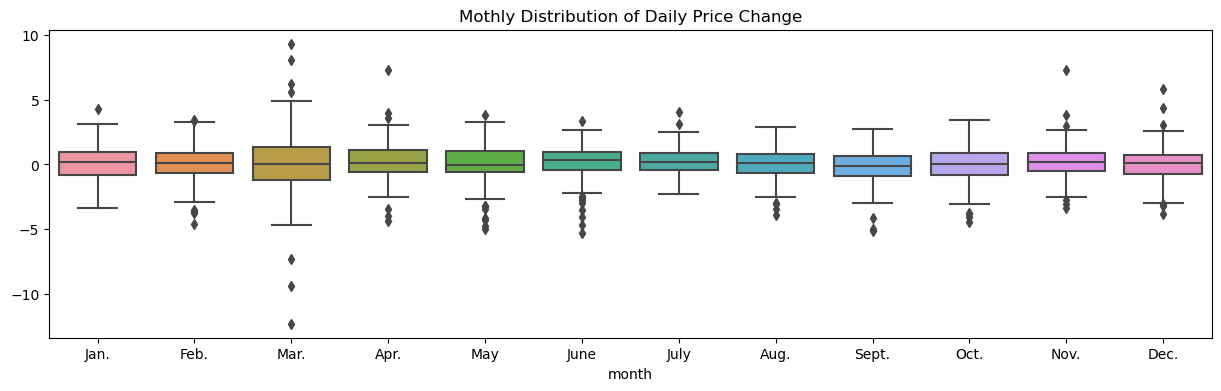

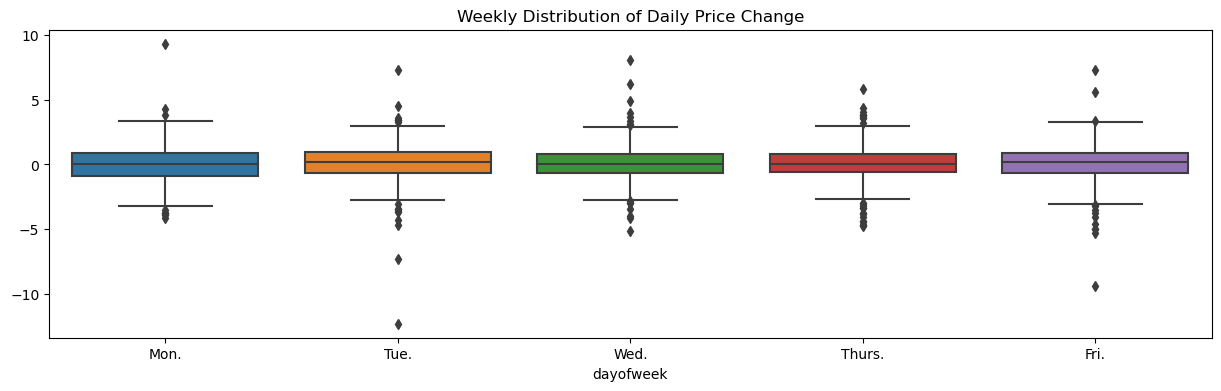

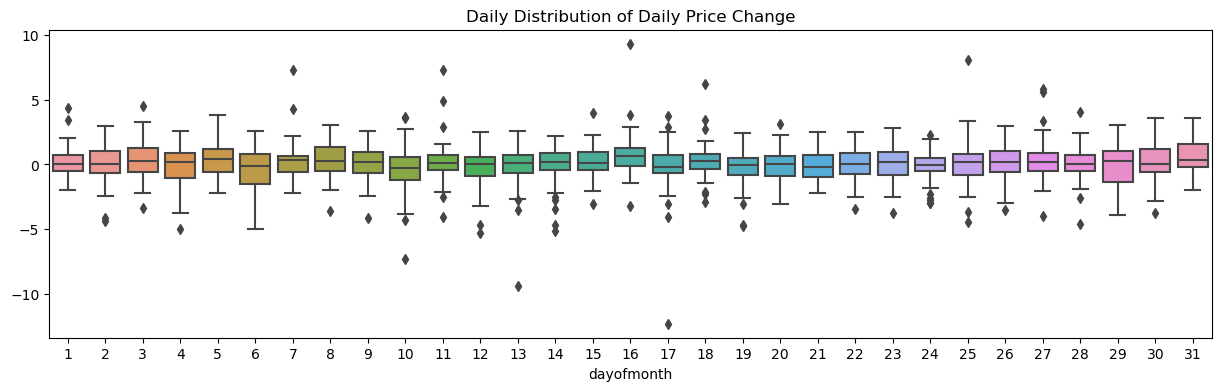

In [13]:
plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "month", y = 'pct_close')
plt.ylabel("")
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11], labels = ["Jan.", "Feb.", "Mar.", "Apr.", "May", "June", "July", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."])
plt.title("Mothly Distribution of Daily Price Change")
plt.show()

plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "dayofweek", y = 'pct_close')
plt.ylabel("")
plt.xticks(ticks = [0, 1,2,3,4], labels = ["Mon.", "Tue.", "Wed.", "Thurs.", "Fri."])
plt.title("Weekly Distribution of Daily Price Change")
plt.show()

plt.figure(figsize=(15,4))
sns.boxplot(data = df_NASDAQ, x = "dayofmonth", y = 'pct_close')
plt.ylabel("")
plt.title("Daily Distribution of Daily Price Change")
plt.show()

<h3>Data Retrieval and Processing</h3>
<p>In this section, the goal is to download and preprocess data for various financial indices and cryptocurrencies. These data points, representing diverse sectors and regions, aim to enrich the analysis, serving as potential exogenous variables to model and predict the behavior of the primary indices, namely NASDAQ and NYSE.</p>
<h4>Indices and Cryptocurrencies:</h4>
<ul>
    <li><strong>BTC-USD:</strong> Bitcoin against the US Dollar. As the pioneering cryptocurrency, Bitcoin's performance can be indicative of the broader sentiment in the digital currency market.</li>
    <li><strong>ETH-USD:</strong> Ethereum against the US Dollar. Ethereum is another major cryptocurrency and often represents innovations in the space like smart contracts.</li>
    <li><strong>^VIX:</strong> CBOE Volatility Index, also known as the "fear index". It measures market risk and investors' sentiments.</li>
    <li><strong>^DJI:</strong> Dow Jones Industrial Average, an index that tracks 30 large, publicly-owned companies trading on the NYSE and NASDAQ.</li>
    <li><strong>^GSPC:</strong> S&P 500 Index, a benchmark for U.S. stock performance. It covers about 80% of the available market capitalization.</li>
    <li><strong>^FTSE:</strong> FTSE 100 Index, representing the 100 largest companies listed on the London Stock Exchange.</li>
    <li><strong>^GDAXI:</strong> DAX 30 Index, tracking the 30 major German companies on the Frankfurt Stock Exchange.</li>
    <li><strong>^FCHI:</strong> CAC 40 Index, a benchmark for the French stock market, representing its 40 most significant equities.</li>
    <li><strong>^N225:</strong> Nikkei 225 Index, an index tracking 225 top-rated companies listed in the Tokyo Stock Exchange.</li>
    <li><strong>^HSI:</strong> Hang Seng Index, representing the 50 largest companies traded on the Hong Kong Exchange.</li>
    <li><strong>^AXJO:</strong> S&P/ASX 200 Index, a benchmark for the Australian equity market, covering its top 200 companies.</li>
    <li><strong>^KS11:</strong> KOSPI Composite Index, a reflection of South Korean companies and a barometer for the South Korean economy.</li>
    <li><strong>^BSESN:</strong> BSE SENSEX, a representation of 30 significant companies listed on the Bombay Stock Exchange.</li>
    <li><strong>^BVSP:</strong> Bovespa Index, representing around 60 stocks traded on the São Paulo Stock Exchange, Brazil.</li>
    <li><strong>GC=F:</strong> Gold Futures, providing a view into the future expectations of the price of gold.</li>
    <li><strong>SI=F:</strong> Silver Futures, indicating anticipated price movements in silver.</li>
    <li><strong>CL=F:</strong> Crude Oil WTI Futures, reflecting expectations about crude oil prices.</li>
    <li><strong>NG=F:</strong> Natural Gas Futures, representing anticipated pricing for natural gas.</li>
    <li><strong>ZC=F:</strong> Corn Futures, providing insight into future corn price movements.</li>
    <li><strong>ZW=F:</strong> Wheat Futures, reflecting expected price shifts in wheat.</li>
</ul>
<h4>Function Explanation:</h4>
<p>The function <code>get_indices_pct_change</code> is designed to retrieve the historical data of the aforementioned indices and cryptocurrencies for a span of 5 years. This data, specifically the 'Close' price, is then consolidated into a single dataframe, facilitating subsequent analyses. By organizing data this way, it becomes efficient to observe and compare the daily movements and correlations among different indices and their potential influence on NASDAQ and NYSE.</p>

In [14]:
indices = [
    "BTC-USD",
    "ETH-USD",
    "^VIX",    # CBOE Volatility Index (VIX)
    "^DJI",    # Dow Jones Industrial Average
    "^GSPC",   # S&P 500 Index
    "^FTSE",   # FTSE 100 Index (UK)
    "^GDAXI",  # DAX 30 Index (Germany)
    "^FCHI",   # CAC 40 Index (France)
    "^N225",   # Nikkei 225 Index (Japan)
    "^HSI",    # Hang Seng Index (Hong Kong)
    "^AXJO",   # S&P/ASX 200 Index (Australia)
    "^KS11",   # KOSPI Composite Index (South Korea)
    "^BSESN",  # BSE SENSEX (India)
    "^BVSP",   # Bovespa Index (Brazil)
    "GC=F",    # Gold Futures
    "SI=F",    # Silver Futures
    "CL=F",    # Crude Oil WTI Futures
    "NG=F",    # Natural Gas Futures
    "ZC=F",    # Corn Futures
    "ZW=F",    # Wheat Futures
]

def get_indices_pct_change(indices):
    data = {index: yf.Ticker(index).history(period="5y") for index in indices}

    indices = []
    for key in data.keys():
        df_indice = data[key][["Close"]]
        df_indice.index = df_indice.index.date
        df_indice.columns = [key]
        indices.append(df_indice)

    df_indices = pd.concat(indices, axis = 1)
    return df_indices

In [15]:
df_indices = get_indices_pct_change(indices)
df_indices

BTC-USD  ETH-USD  ^VIX     ^DJI   ^GSPC   ^FTSE   ^GDAXI   ^FCHI  \
2018-08-21  6488.76   281.94 12.86 25822.29 2862.96 7565.70 12384.49 5408.60   
2018-08-22  6376.71   271.34 12.25 25733.60 2861.82 7574.20 12385.70 5420.61   
2018-08-23  6534.88   277.10 12.41 25656.98 2856.98 7563.20 12365.58 5419.33   
2018-08-24  6719.96   282.97 11.99 25790.35 2874.69 7577.50 12394.52 5432.50   
2018-08-25  6763.19   279.65   NaN      NaN     NaN     NaN      NaN     NaN   
...             ...      ...   ...      ...     ...     ...      ...     ...   
2023-08-15 29170.35  1826.93 16.46 34946.39 4437.86 7389.60 15767.28 7267.70   
2023-08-16 28701.78  1805.66 16.78 34765.74 4404.33 7356.90 15789.45 7260.25   
2023-08-17 26664.55  1684.93 17.89 34474.83 4370.36 7310.20 15676.90 7191.74   
2023-08-18 26049.56  1660.95 17.30 34500.66 4369.71 7262.40 15574.26 7164.11   
2023-08-21 26047.81  1662.79 17.30 34422.81 4388.99 7257.82 15603.28 7198.06   

              ^N225     ^HSI   ^AXJO   ^KS11   ^BSESN     ^BVSP    GC=F  SI=F  \
2018-08-21 22219.73 27752.79 6284.40 2270.06 38285.75  75180.00 1192.60 14.75   
2018-08-22 22362.55 27927.58 6266.00 2273.33      NaN  76902.00 1196.30 14.73   
2018-08-23 22410.82 27790.46 6244.40 2282.60 38336.76  75634.00 1187.00 14.53   
2018-08-24 22601.77 27671.87 6247.30 2293.21 38251.80  76262.00 1206.30 14.78   
2018-08-25      NaN      NaN     NaN     NaN      NaN       NaN     NaN   NaN   
...             ...      ...     ...     ...      ...       ...     ...   ...   
2023-08-15 32238.89 18581.11 7305.00     NaN      NaN 116171.00 1902.50 22.59   
2023-08-16 31766.82 18329.30 7195.20 2525.64 65539.42 115592.00 1896.10 22.48   
2023-08-17 31626.00 18326.63 7146.00 2519.85 65151.02 114982.00 1884.10 22.67   
2023-08-18 31450.76 17950.85 7148.10 2504.50 64948.66 115409.00 1886.10 22.69   
2023-08-21 31565.64 17623.29 7115.50 2508.80 65216.09 114193.90 1923.00 23.33   

            CL=F  NG=F   ZC=F   ZW=F  
2018-08-21 67.35  2.98 359.75 527.25  
2018-08-22 67.86  2.96 352.50 526.00  
2018-08-23 67.83  2.96 346.75 522.00  
2018-08-24 68.72  2.92 348.50 514.75  
2018-08-25   NaN   NaN    NaN    NaN  
...          ...   ...    ...    ...  
2023-08-15 80.99  2.66 464.00 598.50  
2023-08-16 79.38  2.59 469.50 597.75  
2023-08-17 80.39  2.62 473.00 589.50  
2023-08-18 81.25  2.55 479.50 613.25  
2023-08-21 81.33  2.62 485.50 628.75  

[1825 rows x 20 columns]

<h3>Cyclic Encoding of Time Features</h3>
<p>In the analysis of time series data, especially financial markets, certain time-related features, such as days of the week or weeks of the year, exhibit cyclic patterns. Meaning, after reaching a certain value (like Sunday for day of the week or the 52nd week for weeks of the year), they wrap around to the beginning (Monday or the 1st week). Handling such features linearly might lead to misleading models, as, for example, the difference between Sunday and Monday isn't as significant as the numeric values (6 and 0) might suggest.</p>
<h4>Why Cyclic Encoding?</h4>
<p>To ensure that machine learning algorithms capture the cyclical nature of these features, we can transform them into two dimensions using trigonometric functions: sine and cosine. This transformation is known as cyclic encoding.</p>
<h4>The Encoding Process:</h4>
<ul>
    <li>For each cyclical feature, calculate the sine and cosine values based on its proportion to its maximum value.</li>
    <li>The sine and cosine values will encapsulate the cyclicity of the feature. For instance, for days of the week, the values will cycle every 7 days, while for weeks of the year, the values will cycle every 52 weeks.</li>
    <li>This process results in two new columns for each feature: one for the sine transformation and one for the cosine transformation. These columns replace the original feature, preserving the cyclic nature in a way that's more meaningful for modeling.</li>
</ul>
<h4>Implementation:</h4>
<p>The <code>cycle_encode</code> function takes a dataframe and the columns that need to be cyclically encoded. It then calculates the sine and cosine values for each of these columns and appends them to the dataframe. Post transformation, the original columns are dropped, leaving behind only the cyclically encoded features.</p>
<p>This encoding technique ensures that our models treat time-related features in a more contextually relevant manner, potentially leading to more accurate and insightful results.</p>

In [16]:
def cycle_encode(data, cols):
    for col in cols:
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

cols  = ["dayofweek","weekofyear"]
df_NASDAQ = cycle_encode(df_NASDAQ,cols)
df_NASDAQ.drop(cols, axis=1, inplace=True)
df_NASDAQ.head()

Open    High     Low   Close      Volume  pct_close  win_close  \
2018-08-21 7840.09 7897.68 7836.79 7859.17  1788860000        NaN          0   
2018-08-22 7844.04 7897.63 7840.84 7889.10  1669240000        NaN          0   
2018-08-23 7886.47 7926.32 7866.53 7878.46  1888600000       0.38          1   
2018-08-24 7907.81 7949.71 7907.10 7945.98  1892990000      -0.13          0   
2018-08-27 7989.64 8024.94 7976.60 8017.90  2333790000       0.86          1   

            pct_open  win_open  month  dayofmonth  dayofweek_sin  \
2018-08-21       NaN         0      8          21           1.00   
2018-08-22       NaN         0      8          22           0.00   
2018-08-23     -0.19         0      8          23          -1.00   
2018-08-24     -0.03         0      8          24          -0.00   
2018-08-27      0.37         1      8          27           0.00   

            dayofweek_cos  weekofyear_sin  weekofyear_cos  
2018-08-21           0.00           -0.78           -0.63  
2018-08-22          -1.00           -0.78           -0.63  
2018-08-23          -0.00           -0.78           -0.63  
2018-08-24           1.00           -0.78           -0.63  
2018-08-27           1.00           -0.85           -0.53

<Axes: >

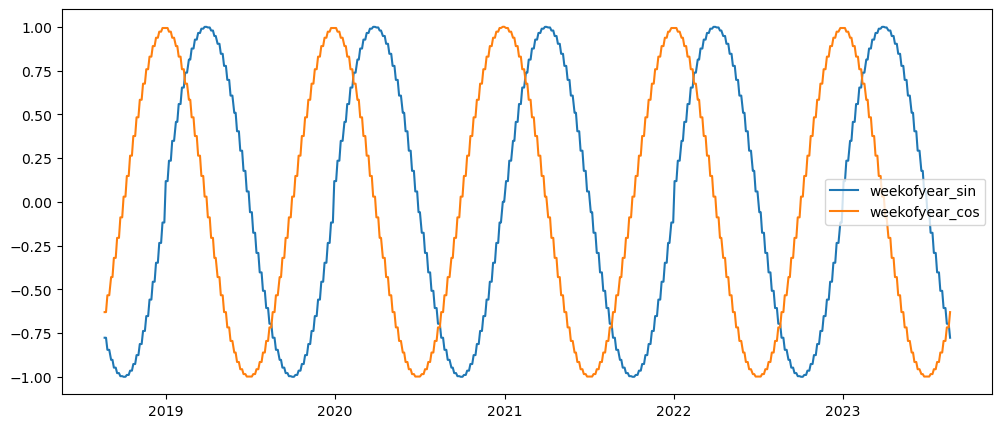

In [17]:
fig,ax = plt.subplots(figsize = (12,5))

df_NASDAQ[["weekofyear_sin","weekofyear_cos"]].plot(ax = ax)

<h3>Understanding Technical Indicators</h3>
<p>Technical analysis is a critical method used to evaluate and predict potential future price movements based on historical data. One of the essential tools in the toolkit of a technical analyst is the use of 'technical indicators'. These indicators are mathematical calculations derived from the price, volume, or open interest of a security or contract. They can provide unique insights into the momentum, volatility, and other market strengths, thereby helping traders to make more informed decisions.</p>
<p>Let's delve into some of the most commonly used technical indicators in the world of finance and understand what they signify:</p>

<ul>
    <li><strong>SMA (Simple Moving Average)</strong>:
        <ul>
            <li>A simple moving average calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. The SMA is an arithmetic mean of the price.</li>
            <li><code>SMA_50</code> is the 50-period simple moving average.</li>
            <li><code>SMA_200</code> is the 200-period simple moving average.</li>
        </ul>
    </li>
    <li><strong>RSI (Relative Strength Index)</strong>:
        <ul>
            <li>RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a traded security.</li>
            <li>Values above 70 are typically considered overbought, and values below 30 are considered oversold.</li>
        </ul>
    </li>
    <li><strong>Momentum</strong>:
        <ul>
            <li>Momentum is a measure of the rate of rise or fall in prices. In this function, it's calculated as the difference between the current closing price and the closing price from 4 periods ago.</li>
        </ul>
    </li>
    <li><strong>Stochastic Oscillator</strong>:
        <ul>
            <li>The stochastic oscillator compares a stock's closing price to its price range over a specific time period.</li>
            <li><code>%K</code> represents the current market rate for the currency pair.</li>
            <li><code>%D</code> is a moving average of %K, typically a 3-day simple moving average.</li>
        </ul>
    </li>
    <li><strong>MACD (Moving Average Convergence Divergence)</strong>:
        <ul>
            <li>MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.</li>
            <li><code>EMA_12</code> is the 12-period exponential moving average.</li>
            <li><code>EMA_26</code> is the 26-period exponential moving average.</li>
            <li>The <code>MACD</code> is calculated by subtracting the 26-period EMA from the 12-period EMA.</li>
            <li>The <code>Signal_Line</code> is a 9-day EMA of the MACD.</li>
        </ul>
    </li>
    <li><strong>ATR (Average True Range)</strong>:
        <ul>
            <li>ATR measures market volatility. It calculates the average of true price ranges over a time period.</li>
            <li><code>TR</code> (True Range) is the greatest of the following:
                <ul>
                    <li>Current high minus the current low.</li>
                    <li>The absolute value of the current high minus the previous close.</li>
                    <li>The absolute value of the current low minus the previous close.</li>
                </ul>
            </li>
            <li>The <code>ATR</code> is a 14-day average of the True Range.</li>
        </ul>
    </li>
    <li><strong>OBV (On-Balance Volume)</strong>:
        <ul>
            <li>OBV is a momentum indicator that uses volume flow to predict changes in stock price.</li>
            <li>It cumulatively adds volume on up days and subtracts volume on down days.</li>
        </ul>
    </li>
    <li><strong>Bollinger Bands</strong>:
        <ul>
            <li>Bollinger Bands consist of a middle band being an N-period simple moving average (SMA), an upper band at K times an N-period standard deviation above the middle band, and a lower band at K times an N-period standard deviation below the middle band.</li>
            <li><code>Middle_Band</code> is the 20-day simple moving average.</li>
            <li><code>Upper_Band</code> is the middle band plus 2 times the 20-day standard deviation of the closing prices.</li>
            <li><code>Lower_Band</code> is the middle band minus 2 times the 20-day standard deviation of the closing prices.</li>
        </ul>
    </li>
</ul>

<p>In the following function, the percentage difference approach has been implemented for several technical indicators, primarily for moving averages like `SMA_50`, `SMA_200`, and `EMA_12`, among others. This approach enables to understand how much the current closing price is above or below its average price over a specified period, offering insights into potential overbought or oversold conditions.</p>
<p>For instance:</p>
<ul>
    <li>The `SMA_50` calculation determines how much the current close is above or below the 50-period simple moving average, represented as a percentage of that average.</li>
    <li>Similarly, the `MACD` value, which is the difference between two EMAs, is represented as a percentage difference, emphasizing the magnitude of divergence between these moving averages.</li>
</ul>
<h4>Conclusion:</h4>
<p>Using percentage differences in technical indicators provides a relative understanding of market conditions. It assists in identifying overextended price movements and potential reversal points, making it a valuable tool for traders and analysts alike.</p>

In [18]:
def add_technical_indicators(df):
    
    """
    Add technical indicators to the given dataframe of stock data.

    Parameters:
    - df (pd.DataFrame): A dataframe containing stock data with columns like 'Open', 'Close', 'High', 'Low', etc.
                         The index should be the date.

    Returns:
    - pd.DataFrame: The dataframe enriched with technical indicators.

    Added Indicators:
    1. Day of the week as sine/cosine encoding
    2. Week of the year as sine/cosine encoding
    3. Percentage change of 'Close' and 'Open' from the previous day
    4. Winning indicator for 'Close' and 'Open' (1 if positive percentage change, otherwise 0)
    5. Simple Moving Averages (SMA) for 50 and 200 days
    6. Relative Strength Index (RSI) for 14 days
    7. Momentum (Close difference from 4 days ago)
    8. Stochastic Oscillator (%K and %D for 14 days)
    9. Exponential Moving Averages (EMA) for 12 and 26 days and Moving Average Convergence Divergence (MACD)
    10. Average True Range (ATR) for 14 days
    11. On-Balance Volume (OBV)
    12. Bollinger Bands (Middle, Upper, Lower Band for 20 days)

    Note:
    - The function assumes certain columns are present in the dataframe ('Open', 'Close', 'High', 'Low', etc.)
    - The function will remove the original 'High', 'Low', 'Dividends', and 'Stock Splits' columns from the dataframe.
    - The index will be set to only the date, removing any timestamp if present.
    """
    
    df["dayofweek"]  = pd.to_datetime(df.index).dayofweek    
    df["weekofyear"] = pd.to_datetime(df.index).isocalendar().week.astype("int64")
    df["pct_close"]  = df["Close"].pct_change().shift(1) * 100
    df["win_close"]  = (df["pct_close"] > 0).astype(int)
    df["pct_open"]   = pd.Series((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1) * 100
    df["win_open"]   = (df["pct_open"] > 0).astype(int)
    
    def cycle_encode(data, cols):
        for col in cols:
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        return data

    cols  = ["dayofweek","weekofyear"]
    df = cycle_encode(df,cols)
    df.drop(cols, axis=1, inplace=True)
     
    # Simple Moving Averages (SMA)
    df['SMA_50'] = ((df['Close'] - df['Close'].rolling(window=50).mean()) / df['Close'].rolling(window=50).mean()) * 100
    df['SMA_200'] = ((df['Close'] - df['Close'].rolling(window=200).mean()) / df['Close'].rolling(window=200).mean()) * 100

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(4)

    # Stokastik Osilatör
    low_min  = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['%K'] = (df['Close'] - low_min) * 100 / (high_max - low_min)
    df['%D'] = df['%K'].rolling(window=3).mean()

    # MACD
    df['EMA_12'] = ((df['Close'] - df['Close'].ewm(span=12).mean()) / df['Close'].ewm(span=12).mean()) * 100
    df['EMA_26'] = ((df['Close'] - df['Close'].ewm(span=26).mean()) / df['Close'].ewm(span=26).mean()) * 100
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()

    # Average True Range (ATR)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(np.abs(df['High'] - df['Close'].shift(1)), 
                                     np.abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()

    # On Balance Volume (OBV)
    df['OBV'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                        np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()

    # Bollinger Bands
    df['Middle_Band'] = ((df['Close'] - df['Close'].rolling(window=20).mean()) / df['Close'].rolling(window=20).mean()) * 100
    df['Upper_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) * 100
    df['Lower_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) * 100
    
    df.drop(["High", "Low", "Dividends", "Stock Splits"], axis = 1, inplace = True)
    df.index = df.index.date

    return df

In [19]:
df_NASDAQ = nasdaq.history(period="5y")
df_NASDAQ = add_technical_indicators(df_NASDAQ)
final_df = pd.concat([df_indices, df_NASDAQ], axis = 1)
final_df.tail(10)

BTC-USD  ETH-USD  ^VIX     ^DJI   ^GSPC   ^FTSE   ^GDAXI   ^FCHI  \
2023-08-10 29429.59  1850.75 15.85 35176.15 4468.83 7618.60 15996.52 7433.62   
2023-08-11 29397.71  1847.12 14.84 35281.40 4464.05 7524.20 15832.17 7340.19   
2023-08-12 29415.96  1848.89   NaN      NaN     NaN     NaN      NaN     NaN   
2023-08-13 29282.91  1839.28   NaN      NaN     NaN     NaN      NaN     NaN   
2023-08-14 29408.44  1844.19 14.82 35307.63 4489.72 7507.20 15904.25 7348.84   
2023-08-15 29170.35  1826.93 16.46 34946.39 4437.86 7389.60 15767.28 7267.70   
2023-08-16 28701.78  1805.66 16.78 34765.74 4404.33 7356.90 15789.45 7260.25   
2023-08-17 26664.55  1684.93 17.89 34474.83 4370.36 7310.20 15676.90 7191.74   
2023-08-18 26049.56  1660.95 17.30 34500.66 4369.71 7262.40 15574.26 7164.11   
2023-08-21 26047.81  1662.79 17.30 34422.81 4388.99 7257.82 15603.28 7198.06   

              ^N225     ^HSI  ...  EMA_12  EMA_26  MACD  Signal_Line     TR  \
2023-08-10 32473.65 19248.26  ...   -1.51   -1.32 -0.19        -0.77 260.65   
2023-08-11      NaN 19075.19  ...   -1.85   -1.85 -0.00        -0.61 128.01   
2023-08-12      NaN      NaN  ...     NaN     NaN   NaN          NaN    NaN   
2023-08-13      NaN      NaN  ...     NaN     NaN   NaN          NaN    NaN   
2023-08-14 32059.91 18773.55  ...   -0.69   -0.75  0.06        -0.48 206.67   
2023-08-15 32238.89 18581.11  ...   -1.55   -1.75  0.20        -0.34 176.39   
2023-08-16 31766.82 18329.30  ...   -2.28   -2.67  0.39        -0.19 171.29   
2023-08-17 31626.00 18326.63  ...   -2.91   -3.54  0.63        -0.03 231.64   
2023-08-18 31450.76 17950.85  ...   -2.63   -3.46  0.82         0.14 174.11   
2023-08-21 31565.64 17623.29  ...   -1.17   -2.06  0.88         0.29 170.74   

              ATR             OBV  Middle_Band  Upper_Band  Lower_Band  
2023-08-10 201.21 348979920000.00        -2.46       -5.05        0.29  
2023-08-11 202.28 344341040000.00        -2.95       -5.85        0.12  
2023-08-12    NaN             NaN          NaN         NaN         NaN  
2023-08-13    NaN             NaN          NaN         NaN         NaN  
2023-08-14 206.82 348613060000.00        -1.77       -4.75        1.39  
2023-08-15 209.04 344139740000.00        -2.64       -5.66        0.57  
2023-08-16 196.04 337895980000.00        -3.46       -6.63       -0.07  
2023-08-17 191.57 332615800000.00        -4.33       -7.97       -0.40  
2023-08-18 198.42 327813890000.00        -4.26       -8.32        0.17  
2023-08-21 201.30 330231825000.00        -2.83       -7.09        1.85  

[10 rows x 47 columns]

In [20]:
final_df.isna().sum()

BTC-USD             0
ETH-USD             0
^VIX              567
^DJI              567
^GSPC             567
^FTSE             564
^GDAXI            555
^FCHI             542
^N225             608
^HSI              593
^AXJO             560
^KS11             593
^BSESN            596
^BVSP             585
GC=F              567
SI=F              567
CL=F              567
NG=F              567
ZC=F              569
ZW=F              567
Open              567
Close             567
Volume            567
pct_close         569
win_close         567
pct_open          569
win_open          567
dayofweek_sin     567
dayofweek_cos     567
weekofyear_sin    567
weekofyear_cos    567
SMA_50            616
SMA_200           766
RSI               580
Momentum          571
%K                580
%D                582
EMA_12            567
EMA_26            567
MACD              567
Signal_Line       567
TR                568
ATR               581
OBV               567
Middle_Band       586
Upper_Band

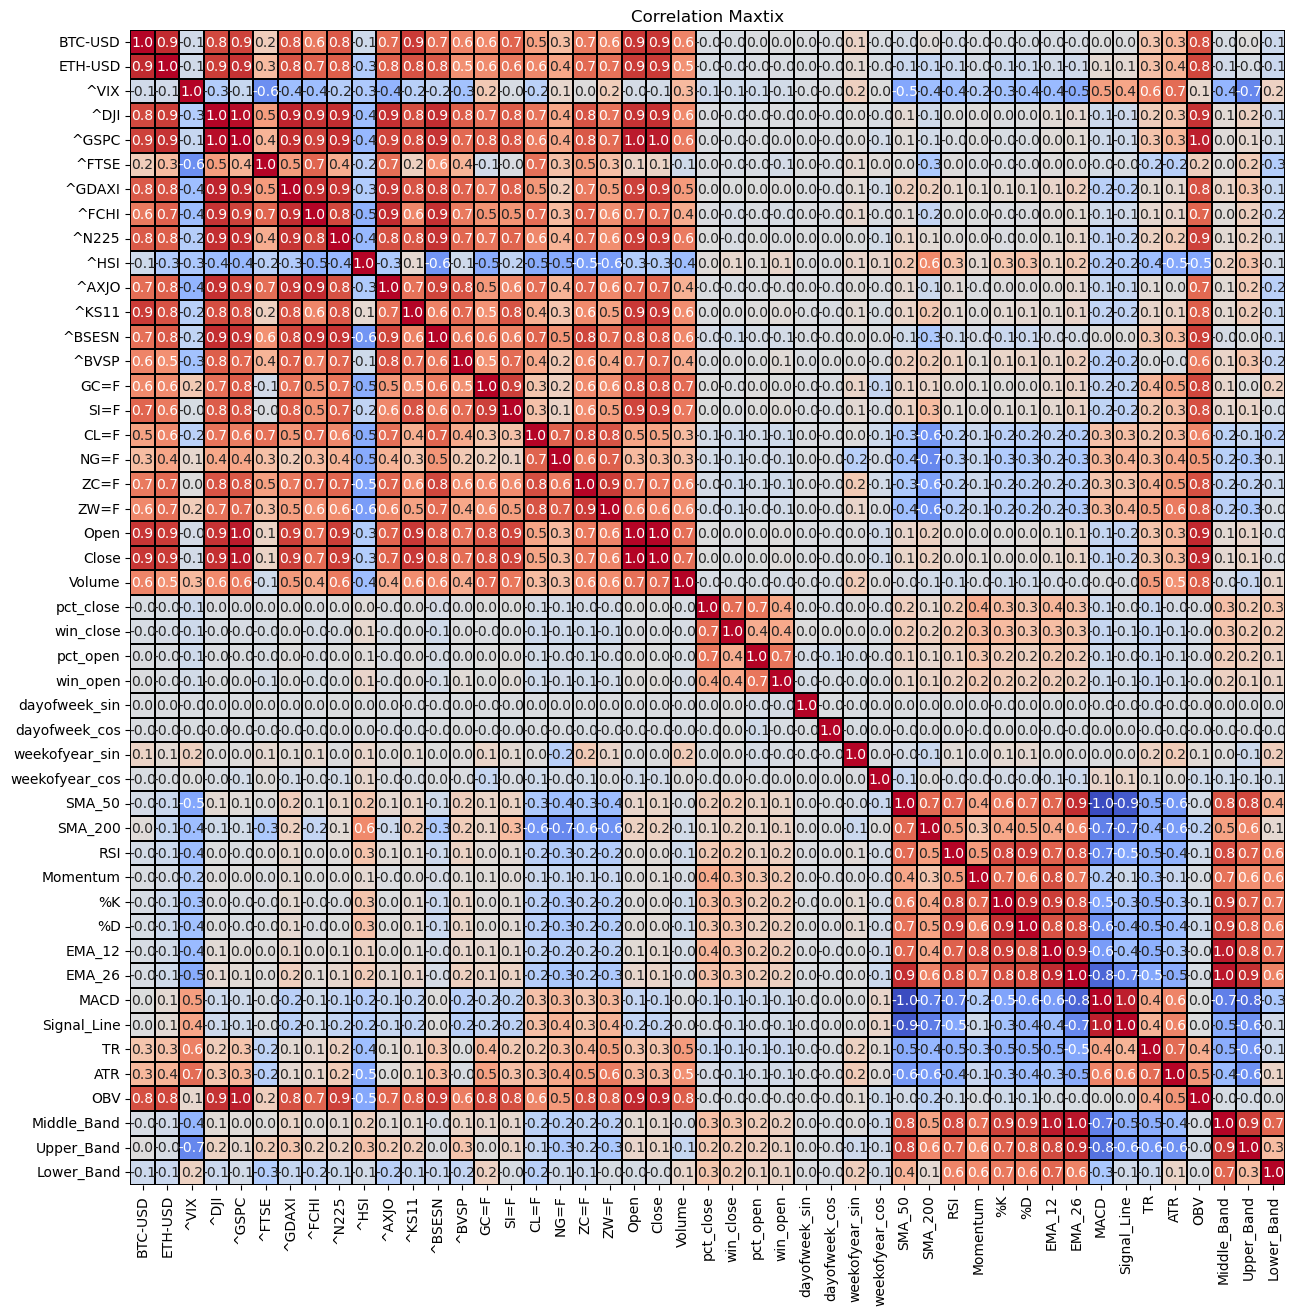

In [21]:
fig, ax = plt.subplots (figsize = (15, 15))
corr_matrix = final_df.corr()

sns.heatmap(corr_matrix,
            cmap= "coolwarm",
            cbar= False,
            square=True,
            annot=True,
            linecolor="black",
            linewidths=0.1,
            fmt= ".1f",
            ax=ax
           )
ax.set_title("Correlation Maxtix", fontsize = 12)
plt.show()

<h3>Using Percentage Change to Reduce Correlation</h3>

<p>In time series data, especially with financial indices, it's common to encounter strong correlations. These correlations can arise from various factors such as similar economic drivers, shared market sentiment, or overlapping constituents. While correlations can be insightful, they can also pose challenges, particularly in modeling and forecasting exercises where multicollinearity or redundancy is a concern.</p>

<h4>Why use Percentage Change?</h4>

1. <strong>Stationarity:</strong> Raw price data, especially in the context of stock indices, tends to be non-stationary. This means that their statistical properties change over time, making modeling and forecasting problematic. Taking the percentage change can often help in achieving stationarity.

2. <strong>Relative Movements:</strong> Using percentage change emphasizes the relative movement of an index rather than its absolute level. This helps in capturing the growth rate or return, which is often more pertinent to analysis than raw prices.

3. <strong>Reduction of Correlation:</strong> By focusing on the changes rather than absolute values, you're essentially capturing the new information or the surprise element in the index, which might be less correlated across different indices. This can be particularly useful when trying to diversify portfolios or when seeking indices that provide unique information.

In [22]:
for idx in indices:
    final_df[idx] = final_df[idx].pct_change()
    
final_df.dropna(inplace = True)

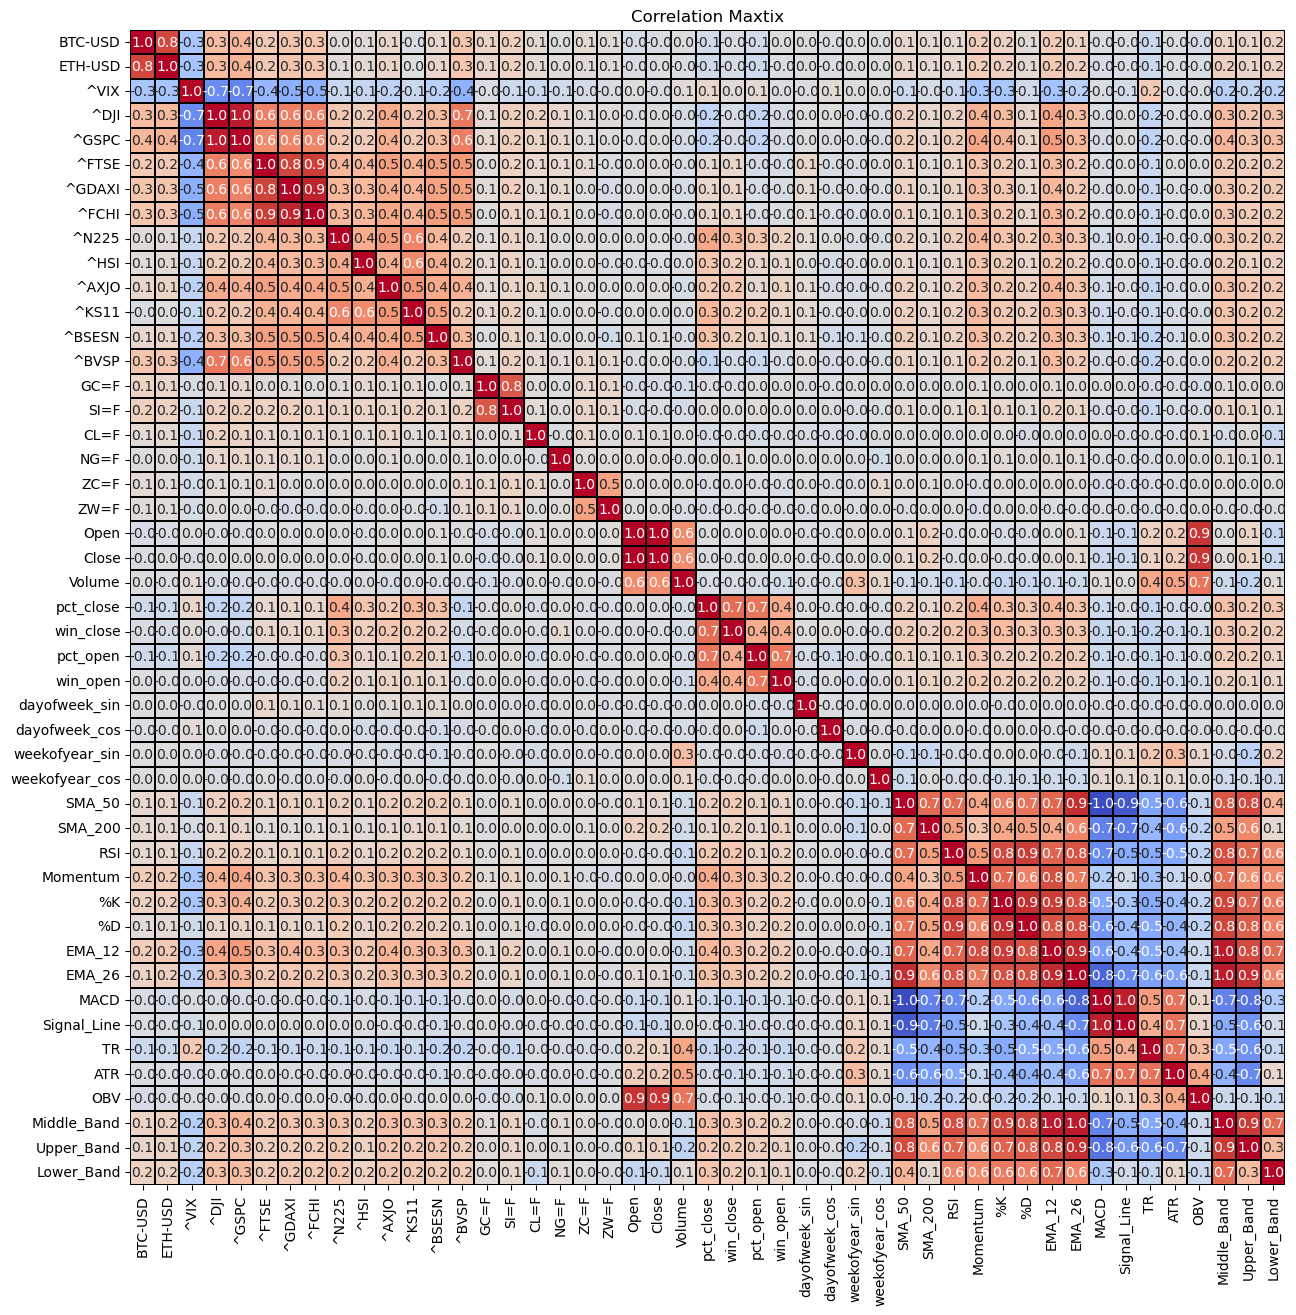

In [23]:
fig, ax = plt.subplots (figsize = (15, 15))
corr_matrix = final_df.corr()

sns.heatmap(corr_matrix,
            cmap= "coolwarm",
            cbar= False,
            square=True,
            annot=True,
            linecolor="black",
            linewidths=0.1,
            fmt= ".1f",
            ax=ax
           )
ax.set_title("Correlation Maxtix", fontsize = 12)
plt.show()

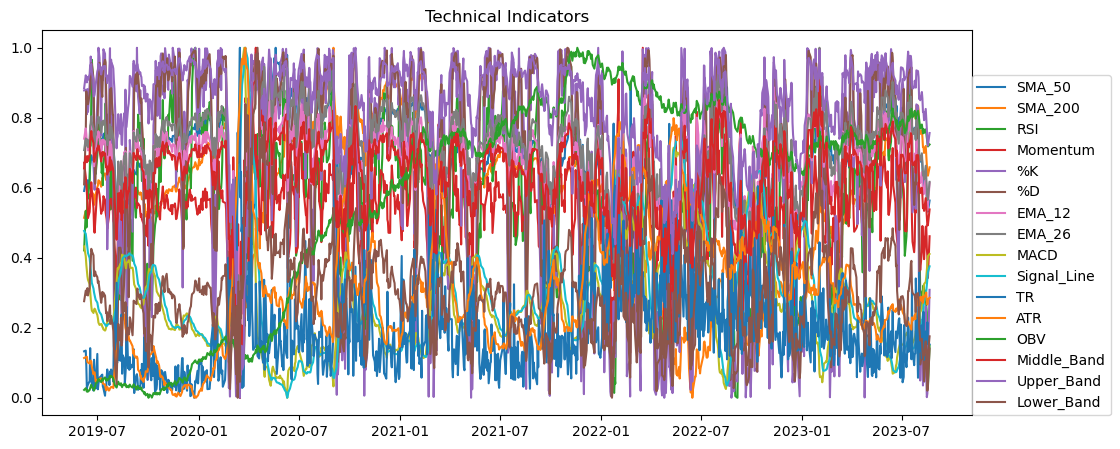

In [24]:
pd.DataFrame(pre.MinMaxScaler().fit_transform(final_df[['SMA_50', 'SMA_200', 'RSI',\
       'Momentum', '%K', '%D', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'TR',\
       'ATR', 'OBV', 'Middle_Band', 'Upper_Band', 'Lower_Band']]), columns=['SMA_50', 'SMA_200', 'RSI',\
       'Momentum', '%K', '%D', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'TR',\
       'ATR', 'OBV', 'Middle_Band', 'Upper_Band', 'Lower_Band'], index = final_df.index).plot(figsize = (12,5))
plt.title("Technical Indicators")
plt.legend(loc = (1,0))
plt.show()

In [25]:
indices = [
    "BTC-USD",
    "ETH-USD",
    "^VIX",    # CBOE Volatility Index (VIX)
    "^DJI",    # Dow Jones Industrial Average
    "^GSPC",   # S&P 500 Index
    "^IXIC",   # NASDAQ Composite Index
    "^FTSE",   # FTSE 100 Index (UK)
    "^GDAXI",  # DAX 30 Index (Germany)
    "^FCHI",   # CAC 40 Index (France)
    "^N225",   # Nikkei 225 Index (Japan)
    "^HSI",    # Hang Seng Index (Hong Kong)
    "^AXJO",   # S&P/ASX 200 Index (Australia)
    "^KS11",   # KOSPI Composite Index (South Korea)
    "^BSESN",  # BSE SENSEX (India)
    "^BVSP",   # Bovespa Index (Brazil)
    "GC=F",    # Gold Futures
    "SI=F",    # Silver Futures
    "CL=F",    # Crude Oil WTI Futures
    "NG=F",    # Natural Gas Futures
    "ZC=F",    # Corn Futures
    "ZW=F",    # Wheat Futures
]

nyse = yf.Ticker("^NYA")
df_NYSE = nyse.history(period="5y")
df_NYSE = add_technical_indicators(df_NYSE)
df_indices_NYSE = get_indices_pct_change(indices)
final_df_NYSE = pd.concat([df_indices_NYSE, df_NYSE], axis = 1)
final_df_NYSE.fillna(method="backfill", inplace=True)

for idx in indices:
    final_df_NYSE[idx] = final_df_NYSE[idx].pct_change()
    
final_df_NYSE.dropna(inplace = True)
print(final_df_NYSE.shape)
final_df_NYSE.tail(10)

(1824, 48)


BTC-USD  ETH-USD  ^VIX  ^DJI  ^GSPC  ^IXIC  ^FTSE  ^GDAXI  ^FCHI  \
2023-08-10    -0.00    -0.00 -0.01  0.00   0.00   0.00   0.00    0.01   0.02   
2023-08-11    -0.00    -0.00 -0.06  0.00  -0.00  -0.01  -0.01   -0.01  -0.01   
2023-08-12     0.00     0.00 -0.00  0.00   0.01   0.01  -0.00    0.00   0.00   
2023-08-13    -0.00    -0.01  0.00  0.00   0.00   0.00   0.00    0.00   0.00   
2023-08-14     0.00     0.00  0.00  0.00   0.00   0.00   0.00    0.00   0.00   
2023-08-15    -0.01    -0.01  0.11 -0.01  -0.01  -0.01  -0.02   -0.01  -0.01   
2023-08-16    -0.02    -0.01  0.02 -0.01  -0.01  -0.01  -0.00    0.00  -0.00   
2023-08-17    -0.07    -0.07  0.07 -0.01  -0.01  -0.01  -0.01   -0.01  -0.01   
2023-08-18    -0.02    -0.01 -0.03  0.00  -0.00  -0.00  -0.01   -0.01  -0.00   
2023-08-21     0.00     0.00  0.00 -0.00   0.00   0.01  -0.00    0.00   0.00   

            ^N225  ...  EMA_12  EMA_26  MACD  Signal_Line     TR    ATR  \
2023-08-10   0.01  ...   -0.32    0.17 -0.49        -0.77 209.78 141.86   
2023-08-11  -0.01  ...   -0.22    0.20 -0.43        -0.71 113.85 142.21   
2023-08-12   0.00  ...   -0.33    0.03 -0.37        -0.64 107.34 144.35   
2023-08-13   0.00  ...   -0.33    0.03 -0.37        -0.64 107.34 144.35   
2023-08-14   0.00  ...   -0.33    0.03 -0.37        -0.64 107.34 144.35   
2023-08-15   0.01  ...   -1.36   -1.15 -0.21        -0.55 218.72 151.01   
2023-08-16  -0.01  ...   -1.64   -1.60 -0.04        -0.45 145.27 146.77   
2023-08-17  -0.00  ...   -1.84   -1.97  0.13        -0.33 179.36 151.59   
2023-08-18  -0.01  ...   -1.47   -1.73  0.26        -0.21 153.29 156.48   
2023-08-21   0.00  ...   -1.48   -1.85  0.38        -0.10 141.36 158.23   

                       OBV  Middle_Band  Upper_Band  Lower_Band  
2023-08-10 191013670000.00        -0.60       -2.09        0.94  
2023-08-11 194766960000.00        -0.58       -2.00        0.88  
2023-08-12 190870550000.00        -0.77       -2.13        0.63  
2023-08-13 190870550000.00        -0.77       -2.13        0.63  
2023-08-14 190870550000.00        -0.77       -2.13        0.63  
2023-08-15 187038300000.00        -1.95       -3.55       -0.31  
2023-08-16 183284390000.00        -2.41       -4.32       -0.41  
2023-08-17 179340690000.00        -2.76       -5.03       -0.39  
2023-08-18 183281090000.00        -2.50       -5.02        0.15  
2023-08-21 183281090000.00        -2.57       -5.26        0.29  

[10 rows x 48 columns]

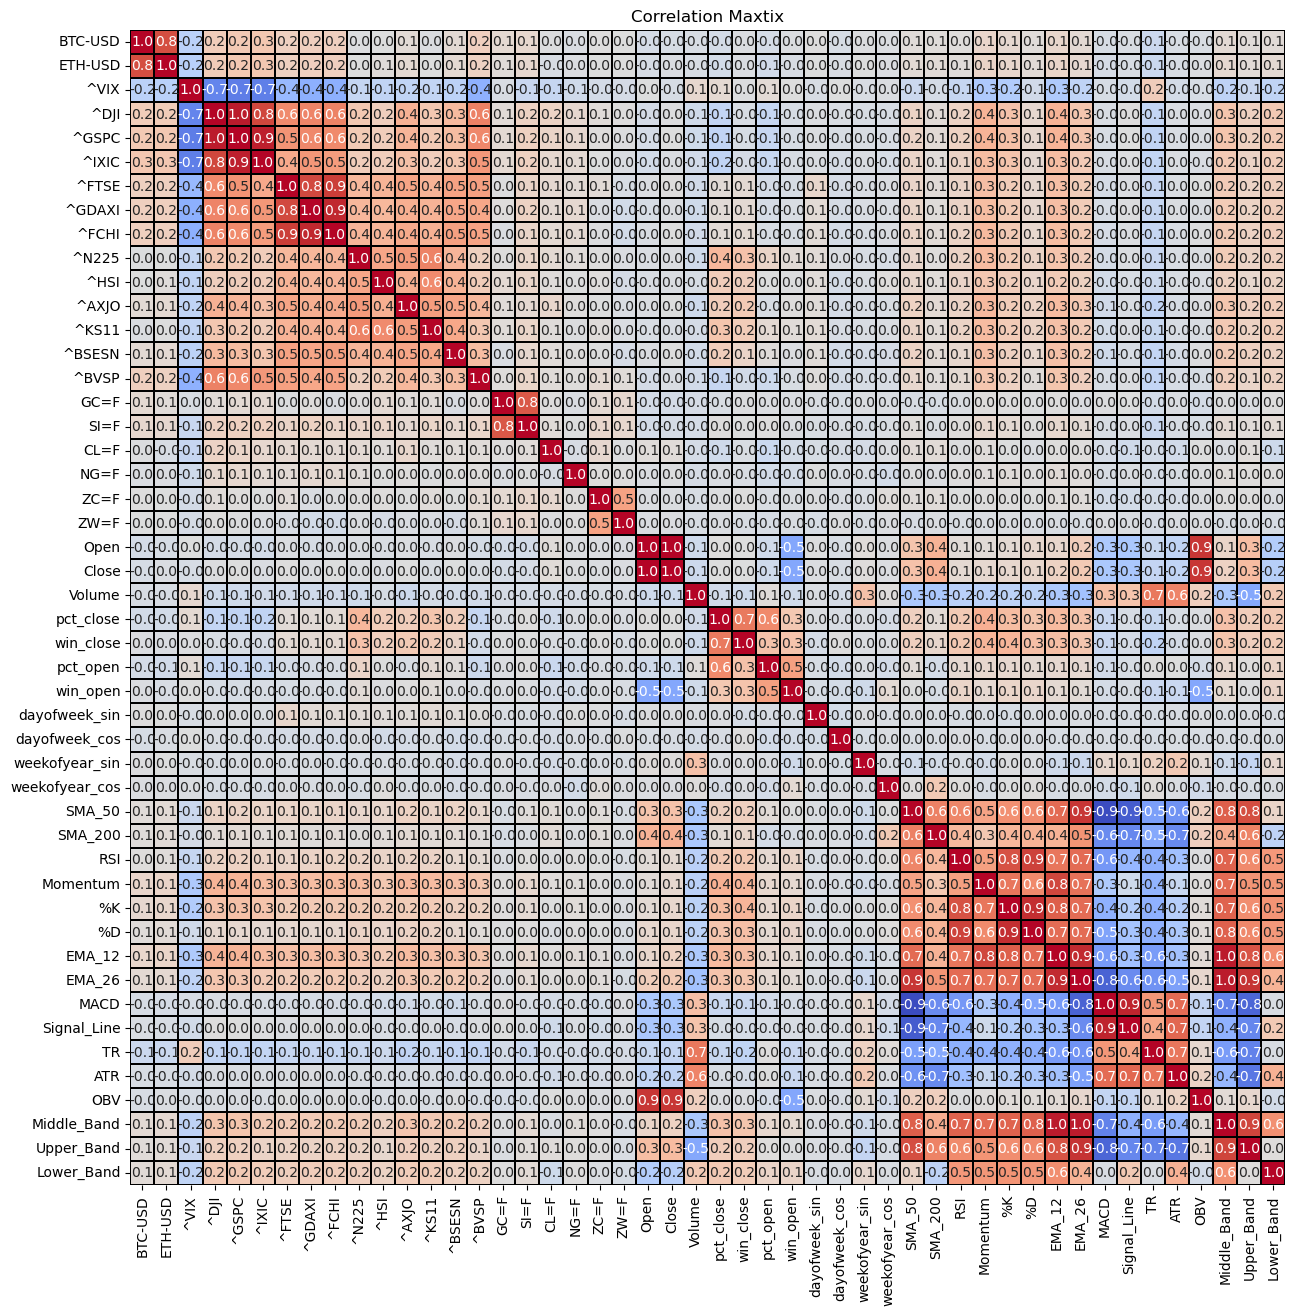

In [26]:
fig, ax = plt.subplots (figsize = (15, 15))
corr_matrix = final_df_NYSE.corr()

sns.heatmap(corr_matrix,
            cmap= "coolwarm",
            cbar= False,
            square=True,
            annot=True,
            linecolor="black",
            linewidths=0.1,
            fmt= ".1f",
            ax=ax
           )
ax.set_title("Correlation Maxtix", fontsize = 12)
plt.show()

In [ ]:
for i in dis_cols:
    fig, ax = plt.subplots(1,2,figsize = (12,5))
    sns.histplot(df_NASDAQ_technical[i], ax=ax[0])
    sns.histplot(np.log1p(df_NASDAQ_technical[i]), ax=ax[1])
    plt.show()

In [27]:
final_df_NYSE.isna().sum()

BTC-USD           0
ETH-USD           0
^VIX              0
^DJI              0
^GSPC             0
^IXIC             0
^FTSE             0
^GDAXI            0
^FCHI             0
^N225             0
^HSI              0
^AXJO             0
^KS11             0
^BSESN            0
^BVSP             0
GC=F              0
SI=F              0
CL=F              0
NG=F              0
ZC=F              0
ZW=F              0
Open              0
Close             0
Volume            0
pct_close         0
win_close         0
pct_open          0
win_open          0
dayofweek_sin     0
dayofweek_cos     0
weekofyear_sin    0
weekofyear_cos    0
SMA_50            0
SMA_200           0
RSI               0
Momentum          0
%K                0
%D                0
EMA_12            0
EMA_26            0
MACD              0
Signal_Line       0
TR                0
ATR               0
OBV               0
Middle_Band       0
Upper_Band        0
Lower_Band        0
dtype: int64